This is probably wrong, though it seems to work. How do we make it right?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import emcee

In [2]:
from scipy.stats import anderson_ksamp, ks_2samp

In [173]:
nsamples = 1000

ref_sample = np.random.normal(loc=2, scale=1.0, size=nsamples)

def lnprob(p): 
    loc, scale = p
    trial_sample = np.random.normal(loc=loc, scale=scale, size=nsamples)

    ad = anderson_ksamp([ref_sample, trial_sample])
    return -ad.statistic

#     ks = ks_2samp(ref_sample, trial_sample)
#     return np.log(ks.pvalue)

def lnprior(p): 
    loc, scale = p
    if -10 < loc < 10 and 0 < scale < 100:
        return 0
    return -np.inf

def lnlike(p):
    lp = lnprior(p)
    if np.isfinite(lp): 
        return lp + lnprob(p)
    
    return -np.inf

In [174]:
nwalkers, ndim = 8, 2

import warnings

with warnings.catch_warnings() as w:
    warnings.simplefilter('ignore')
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, threads=8)

In [175]:
n_steps = 2000

p0 = [[np.random.randn(), 0.2+np.random.rand()]
       for _ in range(nwalkers)]

p1 = sampler.run_mcmc(p0, n_steps//4)[0];
sampler.reset()
p2 = sampler.run_mcmc(p1, n_steps)[0];
sampler.pool.close()

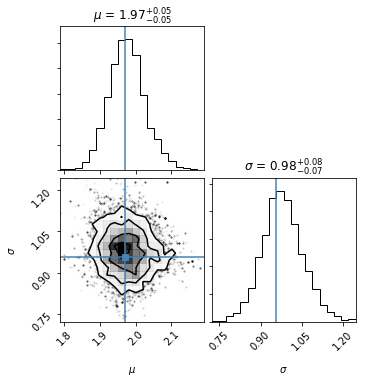

In [176]:
from corner import corner
corner(sampler.flatchain, truths=[ref_sample.mean(), ref_sample.std()], 
       labels='$\mu$ $\sigma$'.split(), show_titles=True);

In [128]:
# The "background" outlier likelihood:

y = ref_sample.copy()
def lnlike_bg(p):
    mu, lnV = p
    var = np.exp(lnV)
    return np.sum(-0.5 * ((mu - y) ** 2 / var + np.log(var)))

nwalkers, ndim = 100, 2

p0 = [1e-5*np.random.randn() + np.array([2, 0]) for _ in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike_bg)

# Run a burn-in chain and save the final location.
pos = sampler.run_mcmc(p0, 500)[0]

# Run the production chain.
sampler.reset()
sampler.run_mcmc(pos, 1500);

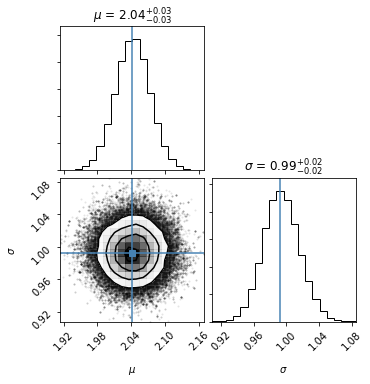

In [129]:
samples = sampler.flatchain.copy()

samples[:, 1] = np.sqrt(np.exp(samples[:, 1]))

corner(samples, truths=[ref_sample.mean(), ref_sample.std()], 
       labels='$\\mu$ $\sigma$'.split(), show_titles=True);

In [130]:
1/np.sqrt(nsamples)

0.031622776601683791